# NCF Tensorflow

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np
import math
import pandas as pd
from ast import literal_eval as make_tuple
from time import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Multiply, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

In [4]:
data_path = "https://raw.githubusercontent.com/sparsh-ai/rec-data-public/master/dump/"
train_file_path_movielens = "ml-1m.train.rating"
negative_file_path_movielens = "ml-1m.test.negative"

train_file_path_pinterest = "pinterest-20.train.rating"
negative_file_path_pinterest = "pinterest-20.test.negative"

In [5]:
!wget -nc {data_path+train_file_path_movielens}
!wget -nc {data_path+negative_file_path_movielens}
!wget -nc {data_path+train_file_path_pinterest}
!wget -nc {data_path+negative_file_path_pinterest}

File ‘ml-1m.train.rating’ already there; not retrieving.

File ‘ml-1m.test.negative’ already there; not retrieving.

File ‘pinterest-20.train.rating’ already there; not retrieving.

File ‘pinterest-20.test.negative’ already there; not retrieving.



In [6]:
batch_size = 2**13 #(8192)
K = 10
epochs = 10

In [7]:
def number_users_and_items(path, sep='\t', title_columns=False):
    file = open(file=path, mode='r')
    num_users, num_items = 0, 0
    if title_columns:
        file.readline()
    for line in file.readlines():
        split_line = line.split(sep=sep)
        userID, itemID = int(split_line[0]), int(split_line[1])
        if userID > num_users:
            num_users = userID
        if itemID > num_items:
            num_items = itemID
    file.close()
    return num_users+1, num_items+1 # we add one to take into account userID 0 and itemID 0

In [8]:
def get_train_set(path, num_negative_instances, num_items):
    data = []
    file = open(file=path, mode='r')
    current_user = 0
    interactions_per_user = []
    for line in file:
        split_line = line.split('\t')[:-1]
        user, item = int(split_line[0]), int(split_line[1])
        if user == current_user:
            interactions_per_user.append(item)
            data.append([user, item, 1])
        else:
            num_interactions = len(interactions_per_user)
            for i in range(num_negative_instances * num_interactions):
                random_item = np.random.randint(num_items)
                while (random_item in interactions_per_user):
                    random_item = np.random.randint(num_items)
                data.append([current_user, random_item, 0])
            data.append([user, item, 1])
            current_user = user
            interactions_per_user = [item]
    num_interactions = len(interactions_per_user)
    for i in range(num_negative_instances * num_interactions):
        random_item = np.random.randint(num_items)
        while (random_item in interactions_per_user):
            random_item = np.random.randint(num_items)
        data.append([current_user, random_item, 0])
    file.close()
    return np.array(data)

def get_test_set(negative_filepath):
    test_set = []
    negative_file = open(file=negative_filepath, mode="r")
    for line in negative_file:
        split_line = line.split(sep="\t")
        (user, positive_item) = make_tuple(split_line[0])
        items = [positive_item]+[int(split_line[i]) for i in range(1,len(split_line))]
        test_set.append(items)
    negative_file.close()
    return np.array(test_set)

In [9]:
print("\n*** Preprocessing of data ***")

start = time()

num_users_movielens, num_items_movielens = number_users_and_items(path=train_file_path_movielens)
train_set_movielens = get_train_set(path=train_file_path_movielens, num_negative_instances=4, num_items=num_items_movielens)
test_set_movielens = get_test_set(negative_filepath=negative_file_path_movielens)
print("\nDataset MovieLens")
print("Number of users : {}".format(num_users_movielens))
print("Number of items : {}".format(num_items_movielens))
print("Number of training interactions : {}".format(len(train_set_movielens)))
train_features_movielens = [train_set_movielens[:,0], train_set_movielens[:,1]]
train_labels_movielens = train_set_movielens[:,2]

num_users_pinterest, num_items_pinterest = number_users_and_items(path=train_file_path_pinterest)
train_set_pinterest = get_train_set(path=train_file_path_pinterest, num_negative_instances=4, num_items=num_items_pinterest)
test_set_pinterest = get_test_set(negative_filepath=negative_file_path_pinterest)
print("\nDataset Pinterest")
print("Number of users : {}".format(num_users_pinterest))
print("Number of items : {}".format(num_items_pinterest))
print("Number of training interactions : {}".format(len(train_set_pinterest)))
train_features_pinterest = [train_set_pinterest[:,0], train_set_pinterest[:,1]]
train_labels_pinterest = train_set_pinterest[:,2]

run_time = time()-start
print("Running time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))

print("\nDatasets loaded successfully !")


*** Preprocessing of data ***

Dataset MovieLens
Number of users : 6040
Number of items : 3706
Number of training interactions : 4970845

Dataset Pinterest
Number of users : 55187
Number of items : 9916
Number of training interactions : 7228110
Running time : 1 min 41 sec

Datasets loaded successfully !


In [10]:
def get_model_MF(num_users, num_items, factors=8):
    d = factors
    
    user_input_MF = Input(shape=(1,), dtype='int32', name='user_input_MF')
    item_input_MF = Input(shape=(1,), dtype='int32', name='item_input_MF')

    user_embedding_MF = Embedding(input_dim=num_users, output_dim=d, name='user_embedding_MF')(user_input_MF)
    item_embedding_MF = Embedding(input_dim=num_items, output_dim=d, name='item_embedding_MF')(item_input_MF)

    user_latent_MF = Flatten()(user_embedding_MF)
    item_latent_MF = Flatten()(item_embedding_MF)
    
    dot = Dot(axes=1)([user_latent_MF, item_latent_MF])

    MF = Model(inputs=[user_input_MF, item_input_MF], outputs=dot)
    MF.compile(optimizer=tf.train.AdamOptimizer(), loss=binary_crossentropy)
    return MF

MF = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens)
MF.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input_MF (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input_MF (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding_MF (Embedding)   (None, 1, 8)         48320       user_input_MF[0][0]              
_____________________________________________________________________________________________

In [11]:
## GMF model
def get_model_GMF(num_users, num_items, factors=8):
    d=factors
    user_input_GMF = Input(shape=(1,), dtype='int32', name='user_input_GMF')
    item_input_GMF = Input(shape=(1,), dtype='int32', name='item_input_GMF')

    user_embedding_GMF = Embedding(input_dim=num_users, output_dim=d, name='user_embedding_GMF')
    item_embedding_GMF = Embedding(input_dim=num_items, output_dim=d, name='item_embedding_GMF')

    user_latent_GMF = Flatten()(user_embedding_GMF(user_input_GMF))
    item_latent_GMF = Flatten()(item_embedding_GMF(item_input_GMF))

    mul = Multiply()([user_latent_GMF, item_latent_GMF]) # len = factors

    prediction_GMF = Dense(units=1, activation='sigmoid', name='prediction')(mul)

    GMF = Model(inputs=[user_input_GMF, item_input_GMF], outputs=prediction_GMF)
    GMF.compile(optimizer=tf.train.AdamOptimizer(), loss=binary_crossentropy)
    return GMF

GMF_movielens = get_model_GMF(num_users=num_users_movielens, num_items=num_items_movielens)
GMF_movielens.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input_GMF (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input_GMF (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding_GMF (Embedding)  (None, 1, 8)         48320       user_input_GMF[0][0]             
__________________________________________________________________________________________________
item_embedding_GMF (Embedding)  (None, 1, 8)         29648       item_input_GMF[0][0]            

In [12]:
def get_model_MLP(num_users, num_items, num_layers=3, factors=8):
    if num_layers==0:
        d = int(factors/2)
    else:
        d = int((2**(num_layers-2))*factors)
        
    user_input_MLP = Input(shape=(1,), dtype='int32', name='user_input_MLP')
    item_input_MLP = Input(shape=(1,), dtype='int32', name='item_input_MLP')
    
    user_embedding_MLP = Embedding(input_dim=num_users, output_dim=d, name='user_embedding_MLP')(user_input_MLP)
    item_embedding_MLP = Embedding(input_dim=num_items, output_dim=d, name='item_embedding_MLP')(item_input_MLP)
    
    user_latent_MLP = Flatten()(user_embedding_MLP)
    item_latent_MLP = Flatten()(item_embedding_MLP)
    
    concatenation = Concatenate()([user_latent_MLP, item_latent_MLP])
    output = concatenation
    layer_name = 0
    for i in range(num_layers-1,-1,-1):
        layer = Dense(units=(2**i)*factors, activation='relu', name='layer%d' %(layer_name+1))
        output = layer(output)
        layer_name += 1
    prediction_MLP = Dense(units=1, activation='sigmoid', name='prediction_MLP')(output)
    MLP = Model(inputs=[user_input_MLP, item_input_MLP], outputs=prediction_MLP)
    MLP.compile(optimizer=tf.train.AdamOptimizer(), loss=binary_crossentropy)
    return MLP

MLP_movielens = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens)
MLP_movielens.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input_MLP (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input_MLP (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding_MLP (Embedding)  (None, 1, 16)        96640       user_input_MLP[0][0]             
__________________________________________________________________________________________________
item_embedding_MLP (Embedding)  (None, 1, 16)        59296       item_input_MLP[0][0]             
____________________________________________________________________________________________

In [13]:
def get_model_NeuMF(num_users, num_items, num_layers_MLP_part=3, factors=8):
    assert (factors%2)==0
    if num_layers_MLP_part==0:
        d_MLP = int(factors/4)
    else:
        d_MLP = (2**(num_layers_MLP_part-3))*factors

    user_input = Input(shape=(1,), dtype='int32', name='user_input_NeuMF')
    item_input = Input(shape=(1,), dtype='int32', name='item_input_NeuMF')

    ## MLP part
    user_embedding_MLP = Embedding(input_dim=num_users, output_dim=d_MLP, name='user_embedding_MLP')(user_input)
    item_embedding_MLP = Embedding(input_dim=num_items, output_dim=d_MLP, name='item_embedding_MLP')(item_input)

    user_latent_MLP = Flatten()(user_embedding_MLP)
    item_latent_MLP = Flatten()(item_embedding_MLP)

    concatenation_embeddings = Concatenate()([user_latent_MLP, item_latent_MLP])
    
    output_MLP = concatenation_embeddings  
    layer_name = 0
    for i in range(num_layers_MLP_part-2,-2,-1):
        layer = Dense(units=(2**i)*factors, activation='relu', name='layer%d' %(layer_name+1))
        output_MLP = layer(output_MLP)
        layer_name += 1
    
    d_GMF = int(factors/2)
    ## GMF part
    user_embedding_GMF = Embedding(input_dim=num_users, output_dim=d_GMF, name='user_embedding_GMF')
    item_embedding_GMF = Embedding(input_dim=num_items, output_dim=d_GMF, name='item_embedding_GMF')

    user_latent_GMF = Flatten()(user_embedding_GMF(user_input))
    item_latent_GMF = Flatten()(item_embedding_GMF(item_input))

    mul = Multiply()([user_latent_GMF, item_latent_GMF])

    concatenation_of_models = Concatenate(name='final_concatenation')([mul, output_MLP]) # len = factors
    prediction_NeuMF = Dense(units=1, activation='sigmoid', name='prediction')(concatenation_of_models)

    NeuMF = Model(inputs=[user_input, item_input], outputs=prediction_NeuMF)
    NeuMF.compile(optimizer=tf.train.AdamOptimizer(), loss=binary_crossentropy)
    return NeuMF

print()
NeuMF_movielens = get_model_NeuMF(num_users=num_users_movielens, num_items=num_items_movielens)
NeuMF_movielens.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input_NeuMF (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input_NeuMF (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding_MLP (Embedding)  (None, 1, 8)         48320       user_input_NeuMF[0][0]           
__________________________________________________________________________________________________
item_embedding_MLP (Embedding)  (None, 1, 8)         29648       item_input_NeuMF[0][0]           
___________________________________________________________________________________________

In [14]:
def getHitRatio(ranklist, K, positive_item): # à optimiser avec un dictionnaire
    if positive_item in ranklist[:K]:
        return 1
    else:
        return 0

def getNDCG(ranklist, K, positive_item): # à optimiser avec un dictionnaire
    if positive_item in ranklist[:K]:
        ranking_of_positive_item = np.where(ranklist == positive_item)[0][0]
        return math.log(2)/math.log(2+ranking_of_positive_item)
    else:
        return 0

In [15]:
def rank(item_scores):
    list_item_scores = item_scores.tolist()
    ranklist = sorted(list_item_scores, key=lambda item_score: item_score[1], reverse=True)
    ranklist = np.array(ranklist)[:,0].astype('int64')
    return ranklist

def evaluate_models(models, test_set, K):
    hits, ndcgs = [], []
    users = np.array([user for user in range(len(test_set)) for i in range(100)])
    items = test_set.reshape(-1,)
    for model in models:
        hits_model, ndcgs_model = [], []
        predictions = model.predict(x=[users, items], batch_size=len(test_set), verbose=0)
        map_item_scores = np.concatenate((items.reshape((100*len(test_set), 1)), predictions), axis=1)
        for user in range(len(test_set)):
            ranklist_items = rank(item_scores=map_item_scores[100*user:100*(user+1)])
            positive_item = items[100*user]
            hr = getHitRatio(ranklist=ranklist_items, K=K, positive_item=positive_item)
            ndcg = getNDCG(ranklist=ranklist_items, K=K, positive_item=positive_item)
            hits_model.append(hr)
            ndcgs_model.append(ndcg)
        hits.append(np.array(hits_model).mean())
        ndcgs.append(np.array(ndcgs_model).mean())
    return hits, ndcgs

def train_models(models, train_features, train_labels, test_set, batch_size, epochs, K, verbose=2):
    first_hits, first_ndcgs = evaluate_models(models=models, test_set=test_set, K=K)
    first_losses = []
    for model in models:
        loss = model.evaluate(x=train_features, y=train_labels, batch_size=batch_size, verbose=0)
        first_losses.append(loss)
    losses, hits, ndcgs = [first_losses], [first_hits], [first_ndcgs]
    for e in range(epochs):
        print("\nEpoch n°{}/{}".format(e+1, epochs))
        losses_of_this_epoch = []
        for model in models:
            history = model.fit(x=train_features, y=train_labels, batch_size=batch_size, epochs=1, verbose=verbose, shuffle=True)
            losses_of_this_epoch.append(history.history["loss"][0])
        hits_of_this_epoch, ndcgs_of_this_epoch = evaluate_models(models=models, test_set=test_set, K=K)
        hits.append(hits_of_this_epoch)
        ndcgs.append(ndcgs_of_this_epoch)
        losses.append(losses_of_this_epoch)
    return np.array(hits), np.array(ndcgs), np.array(losses)

#### Dataset MovieLens

In [ ]:
start = time()

MF_movielens = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens)
GMF_movielens = get_model_GMF(num_users=num_users_movielens, num_items=num_items_movielens)
MLP_movielens = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens)
NeuMF_movielens = get_model_NeuMF(num_users=num_users_movielens, num_items=num_items_movielens)

models_movielens = [MF_movielens, GMF_movielens, MLP_movielens, NeuMF_movielens]

hits, ndcgs, losses = train_models(models=models_movielens, train_features=train_features_movielens, train_labels=train_labels_movielens, 
                                   test_set=test_set_movielens, batch_size=batch_size, epochs=epochs, K=K)

loss_MF, loss_GMF, loss_MLP, loss_NeuMF = losses[:,0], losses[:,1], losses[:,2], losses[:,3]
hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Epoch n°1/10
4970845/4970845 - 7s - loss: 2.1169
4970845/4970845 - 8s - loss: 0.5209
4970845/4970845 - 11s - loss: 0.3906
4970845/4970845 - 11s - loss: 0.3938

Epoch n°2/10
4970845/4970845 - 6s - loss: 1.7141
4970845/4970845 - 7s - loss: 0.3612
4970845/4970845 - 10s - loss: 0.3509
4970845/4970845 - 10s - loss: 0.3304

Epoch n°3/10
4970845/4970845 - 7s - loss: 1.1168
4970845/4970845 - 7s - loss: 0.3550
4970845/4970845 - 10s - loss: 0.3338
4970845/4970845 - 10s - loss: 0.3114

Epoch n°4/10
4970845/4970845 - 7s - loss: 0.8189
4970845/4970845 - 7s - loss: 0.3530
4970845/4970845 - 10s - loss: 0.3153
4970845/4970845 - 10s - loss: 0.2998

Epoch n°5/10
4970845/4970845 - 6s - loss: 0.6980
4970845/4970845 - 7s - loss: 0.3506
4970845/4970845 - 10s - loss: 0.2989
4970845/4970845 - 10s - loss: 0.2912

Epoch n°6/10
4970845/4970845 - 6s - loss: 0.6237
4970845/4970845 - 7s - loss: 0.3449
4970845/4970845 - 10s - loss: 0.2899
4970845/4970845 - 10s - loss: 0.2847

Epoch n°7/10
4970845/4970845 - 7s - los

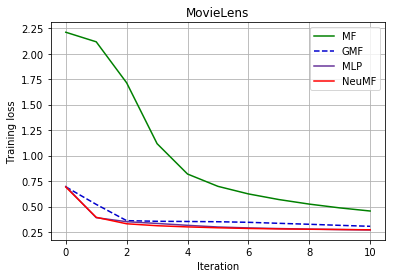

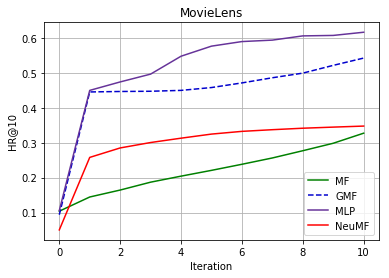

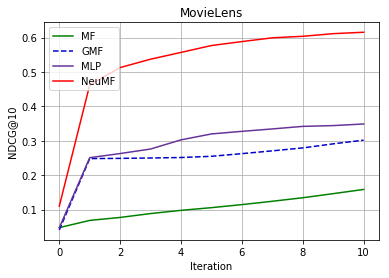

In [ ]:
iterations = [e for e in range(epochs+1)]
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("loss_movieLens")
plt.plot(iterations, loss_MF, color=color_MF)
plt.plot(iterations, loss_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, loss_MLP, color=color_MLP)
plt.plot(iterations, loss_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("MovieLens")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment1_loss_movielens.png")

plt.figure("hits_movieLens")
plt.plot(iterations, hits_MF, color=color_MF)
plt.plot(iterations, hits_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, hits_MLP, color=color_MLP)
plt.plot(iterations, ndcgs_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("HR@"+str(K))
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("MovieLens")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment1_hr_movielens.png")

plt.figure("ndcgs_movielens")
plt.plot(iterations, ndcgs_MF, color=color_MF)
plt.plot(iterations, ndcgs_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, ndcgs_MLP, color=color_MLP)
plt.plot(iterations, hits_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("MovieLens")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment1_ndcg_movielens.png")

plt.show()

#### Dataset Pinterest

In [ ]:
start = time()

MF_pinterest = get_model_MF(num_users=num_users_pinterest, num_items=num_items_pinterest)
GMF_pinterest = get_model_GMF(num_users=num_users_pinterest, num_items=num_items_pinterest)
MLP_pinterest = get_model_MLP(num_users=num_users_pinterest, num_items=num_items_pinterest)
NeuMF_pinterest = get_model_NeuMF(num_users=num_users_pinterest, num_items=num_items_pinterest)

models_pinterest = [MF_pinterest, GMF_pinterest, MLP_pinterest, NeuMF_pinterest]

hits, ndcgs, losses = train_models(models=models_pinterest, train_features=train_features_pinterest, train_labels=train_labels_pinterest, 
                                   test_set=test_set_pinterest, batch_size=batch_size, epochs=epochs, K=K)

loss_MF, loss_GMF, loss_MLP, loss_NeuMF = losses[:,0], losses[:,1], losses[:,2], losses[:,3]
hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Epoch n°1/10
7228110/7228110 - 12s - loss: 2.1348
7228110/7228110 - 13s - loss: 0.5862
7228110/7228110 - 16s - loss: 0.4055
7228110/7228110 - 16s - loss: 0.4487

Epoch n°2/10
7228110/7228110 - 12s - loss: 1.8521
7228110/7228110 - 12s - loss: 0.3983
7228110/7228110 - 16s - loss: 0.2683
7228110/7228110 - 15s - loss: 0.2758

Epoch n°3/10
7228110/7228110 - 12s - loss: 1.6277
7228110/7228110 - 12s - loss: 0.3077
7228110/7228110 - 16s - loss: 0.2364
7228110/7228110 - 16s - loss: 0.2252

Epoch n°4/10
7228110/7228110 - 12s - loss: 1.4093
7228110/7228110 - 12s - loss: 0.2572
7228110/7228110 - 16s - loss: 0.2155
7228110/7228110 - 16s - loss: 0.2035

Epoch n°5/10
7228110/7228110 - 12s - loss: 1.2175
7228110/7228110 - 12s - loss: 0.2293
7228110/7228110 - 16s - loss: 0.2002
7228110/7228110 - 15s - loss: 0.1913

Epoch n°6/10
7228110/7228110 - 12s - loss: 1.0463
7228110/7228110 - 12s - loss: 0.2108
7228110/7228110 - 16s - loss: 0.1893
7228110/7228110 - 16s - loss: 0.1830

Epoch n°7/10
7228110/722811

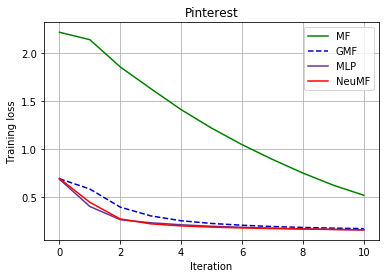

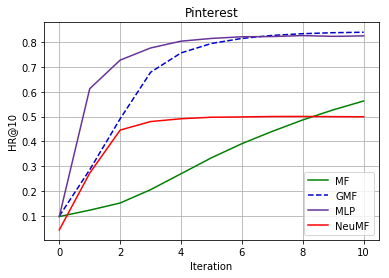

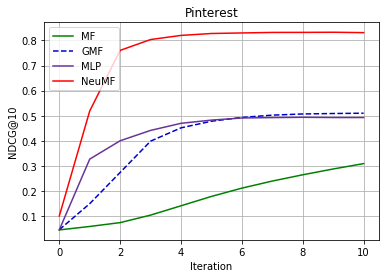

In [ ]:
iterations = [e for e in range(epochs+1)]
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("loss_pinterest")
plt.plot(iterations, loss_MF, color=color_MF)
plt.plot(iterations, loss_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, loss_MLP, color=color_MLP)
plt.plot(iterations, loss_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment1_loss_pinterest.png")

plt.figure("hits_pinterest")
plt.plot(iterations, hits_MF, color=color_MF)
plt.plot(iterations, hits_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, hits_MLP, color=color_MLP)
plt.plot(iterations, ndcgs_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("HR@"+str(K))
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment1_hr_pinterest.png")

plt.figure("ndcgs_pinterest")
plt.plot(iterations, ndcgs_MF, color=color_MF)
plt.plot(iterations, ndcgs_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, ndcgs_MLP, color=color_MLP)
plt.plot(iterations, hits_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment1_ndcg_pinterest.png")

plt.show()

#### Dataset MovieLens

In [ ]:
start = time()

names_models = {0: "MF", 1: "GMF", 2: "MLP", 3: "NeuMF"}

max_num_negative = 10
hits_total, ndcgs_total = [], []
for i in range(1, max_num_negative+1):
    print("\nNumber of negative interactions per positive interaction in train set : {}".format(i))
    train_set = get_train_set(path=train_file_path_movielens, num_negative_instances=i, num_items=num_items_movielens)
    train_features = [train_set[:,0], train_set[:,1]]
    train_labels = train_set[:,2]
    # pour chaque nombre d'instances négatives il faut créer de nouveau modèles et les entrainer à partir de 0
    MF_movielens = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens, factors=16)
    GMF_movielens = get_model_GMF(num_users=num_users_movielens, num_items=num_items_movielens, factors=16)
    MLP_movielens = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens, factors=16)
    NeuMF_movielens = get_model_NeuMF(num_users=num_users_movielens, num_items=num_items_movielens, factors=16)
    models_movielens = [MF_movielens, GMF_movielens, MLP_movielens, NeuMF_movielens]
    k=0
    for model in models_movielens:
        print("-- Training of model {}...".format(names_models[k]))
        history = model.fit(x=train_features, y=train_labels, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
        k+=1
    print("Evaluation...")
    hits, ndcgs = evaluate_models(models=models_movielens, test_set=test_set_movielens, K=K)
    hits_total.append(hits)
    ndcgs_total.append(ndcgs)

hits_total, ndcgs_total = np.array(hits_total), np.array(ndcgs_total)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits_total[:,0], hits_total[:,1], hits_total[:,2], hits_total[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs_total[:,0], ndcgs_total[:,1], ndcgs_total[:,2], ndcgs_total[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Number of negative interactions per positive interaction in train set : 1
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 2
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 3
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 4
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 5
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Eval

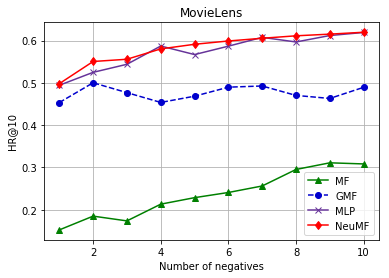

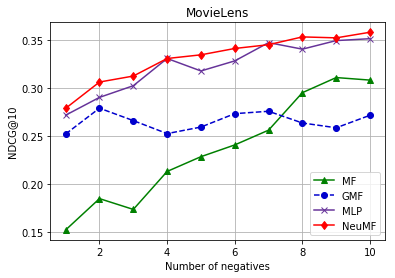

In [ ]:
negatives = [i for i in range(1,max_num_negative+1)]
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("Negative")
plt.plot(negatives, hits_MF, color=color_MF, marker="^")
plt.plot(negatives, hits_GMF, color=color_GMF, linestyle="dashed", marker="o")
plt.plot(negatives, hits_MLP, color=color_MLP, marker="x")
plt.plot(negatives, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of negatives")
plt.ylabel("HR@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("MovieLens")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment2_hr_movielens.png")

plt.figure("Negative2")
plt.plot(negatives, hits_MF, color=color_MF, marker="^")
plt.plot(negatives, ndcgs_GMF, color=color_GMF, linestyle="dashed", marker="o")
plt.plot(negatives, ndcgs_MLP, color=color_MLP, marker="x")
plt.plot(negatives, ndcgs_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of negatives")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("MovieLens")
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment2_ndcg_movielens.png")

plt.show()

#### Dataset Pinterest

In [ ]:
start = time()

names_models = {0: "MF", 1: "GMF", 2: "MLP", 3: "NeuMF"}

max_num_negative = 10
hits_total, ndcgs_total = [], []
for i in range(1, max_num_negative+1):
    print("\nNumber of negative interactions per positive interaction in train set : {}".format(i))
    train_set = get_train_set(path=train_file_path_pinterest, num_negative_instances=i, num_items=num_items_pinterest)
    train_features = [train_set[:,0], train_set[:,1]]
    train_labels = train_set[:,2]
    # pour chaque nombre d'instances négatives il faut entrainer de nouveaux modèles
    MF_pinterest = get_model_MF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=16)
    GMF_pinterest = get_model_GMF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=16)
    MLP_pinterest = get_model_MLP(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=16)
    NeuMF_pinterest = get_model_NeuMF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=16)
    models_pinterest = [MF_pinterest, GMF_pinterest, MLP_pinterest, NeuMF_pinterest]
    k=0
    for model in models_pinterest:
        print("-- Training of model {}...".format(names_models[k]))
        history = model.fit(x=train_features, y=train_labels, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
        k+=1
    print("Evaluation...")
    hits, ndcgs = evaluate_models(models=models_pinterest, test_set=test_set_pinterest, K=K)
    hits_total.append(hits)
    ndcgs_total.append(ndcgs)

hits_total, ndcgs_total= np.array(hits_total), np.array(ndcgs_total)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits_total[:,0], hits_total[:,1], hits_total[:,2], hits_total[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs_total[:,0], ndcgs_total[:,1], ndcgs_total[:,2], ndcgs_total[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Number of negative interactions per positive interaction in train set : 1
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 2
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 3
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 4
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Evaluation...

Number of negative interactions per positive interaction in train set : 5
-- Training of model MF...
-- Training of model MLP...
-- Training of model GMF...
-- Training of model NeuMF...
Eval

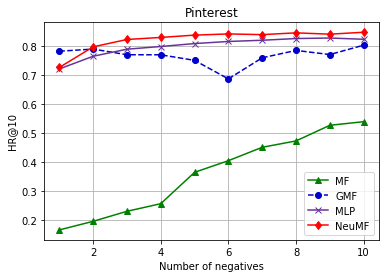

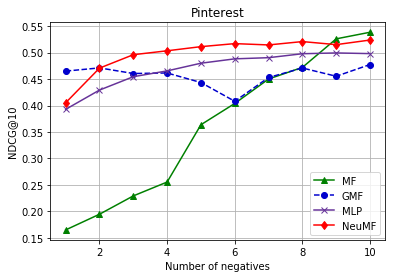

In [ ]:
negatives = [i for i in range(1,max_num_negative+1)]
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("Negative")
plt.plot(negatives, hits_MF, color=color_MF, marker="^")
plt.plot(negatives, hits_GMF, color=color_GMF, linestyle="dashed", marker="o")
plt.plot(negatives, hits_MLP, color=color_MLP, marker="x")
plt.plot(negatives, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of negatives")
plt.ylabel("HR@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment2_hr_pinterest.png")

plt.figure("Negative2")
plt.plot(negatives, hits_MF, color=color_MF, marker="^")
plt.plot(negatives, ndcgs_GMF, color=color_GMF, linestyle="dashed", marker="o")
plt.plot(negatives, ndcgs_MLP, color=color_MLP, marker="x")
plt.plot(negatives, ndcgs_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of negatives")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment2_ndcg_pinterest.png")

plt.show()

#### Dataset MovieLens

In [ ]:
start = time()

factors = [8,16,32,64]
hits, ndcgs = [], []

for f in factors:
    print("Training for {:.0f} predictive factors...".format(f))
    #layers_MLP, layers_NeuMF = [4*f, 2*f, f], [2*f, f, int(f/2)]
    MF = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens, factors=f)
    GMF = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens, factors=f)
    MLP = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens, factors=f)
    NeuMF = get_model_NeuMF(num_users=num_users_movielens, num_items=num_items_movielens, factors=f)
    models = [MF, GMF, MLP, NeuMF]
    for model in models:
        model.fit(x=train_features_movielens, y=train_labels_movielens, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
    print("Evaluation...\n")
    hit, ndcg = evaluate_models(models=models, test_set=test_set_movielens, K=K)
    hits.append(hit)
    ndcgs.append(ndcg)

hits, ndcgs = np.array(hits), np.array(ndcgs)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))

Training for 8 predictive factors...
Evaluation...

Training for 16 predictive factors...
Evaluation...

Training for 32 predictive factors...
Evaluation...

Training for 64 predictive factors...
Evaluation...


Running time : 9 min 6 sec


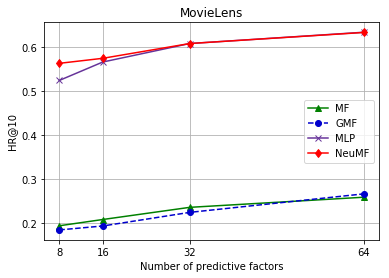

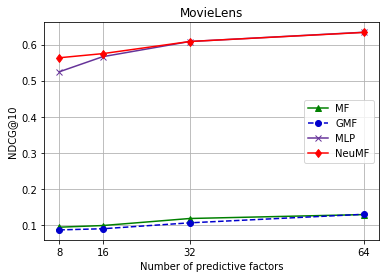

In [ ]:
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("Factors")
plt.plot(factors, hits_MF, color=color_MF, marker="^")
plt.plot(factors, hits_GMF, color=color_GMF, marker="o", linestyle="dashed")
plt.plot(factors, hits_MLP, color=color_MLP, marker="x")
plt.plot(factors, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of predictive factors")
plt.ylabel("HR@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("MovieLens")
plt.xticks(factors)
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment3_hr_movielens.png")

plt.figure("Factors2")
plt.plot(factors, ndcgs_MF, color=color_MF, marker="^")
plt.plot(factors, ndcgs_GMF, color=color_GMF, marker="o", linestyle="dashed")
plt.plot(factors, hits_MLP, color=color_MLP, marker="x")
plt.plot(factors, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of predictive factors")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("MovieLens")
plt.xticks(factors)
plt.grid()
#plt.savefig(fname=path_to_save_figures+"experiment3_ndcg_movielens.png")

plt.show()

#### Dataset Pinterest

On fait de même sur le dataset Pinterest.

In [ ]:
start = time()

factors = [8,16,32,64]
hits, ndcgs = [], []

for f in factors:
    print("Training for {:.0f} predictive factors...".format(f))
    MF = get_model_MF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=f)
    GMF = get_model_MF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=f)
    MLP = get_model_MLP(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=f)
    NeuMF = get_model_NeuMF(num_users=num_users_pinterest, num_items=num_items_pinterest, factors=f)
    models = [MF, GMF, MLP, NeuMF]
    for model in models:
        model.fit(x=train_features_pinterest, y=train_labels_pinterest, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
    print("Evaluation...\n")
    hit, ndcg = evaluate_models(models=models, test_set=test_set_pinterest, K=K)
    hits.append(hit)
    ndcgs.append(ndcg)

hits, ndcgs = np.array(hits), np.array(ndcgs)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))

Training for 8 predictive factors...
Evaluation...

Training for 16 predictive factors...
Evaluation...

Training for 32 predictive factors...
Evaluation...

Training for 64 predictive factors...
Evaluation...


Running time : 19 min 40 sec


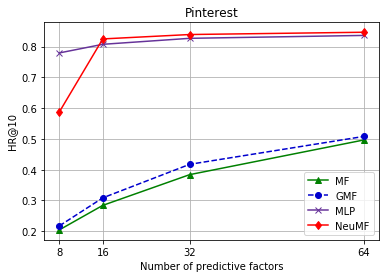

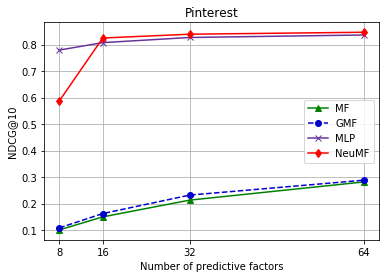

In [ ]:
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("Factors")
plt.plot(factors, hits_MF, color=color_MF, marker="^")
plt.plot(factors, hits_GMF, color=color_GMF, marker="o", linestyle="dashed")
plt.plot(factors, hits_MLP, color=color_MLP, marker="x")
plt.plot(factors, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of predictive factors")
plt.ylabel("HR@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.xticks(factors)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment3_hr_pinterest.png")

plt.figure("Factors2")
plt.plot(factors, ndcgs_MF, color=color_MF, marker="^")
plt.plot(factors, ndcgs_GMF, color=color_GMF, marker="o", linestyle="dashed")
plt.plot(factors, hits_MLP, color=color_MLP, marker="x")
plt.plot(factors, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("Number of predictive factors")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.xticks(factors)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment3_ndcg_pinterest.png")

plt.show()

#### Dataset MovieLens

In [ ]:
MF = get_model_MF(num_users=num_users_movielens, num_items=num_items_movielens)
GMF = get_model_GMF(num_users=num_users_movielens, num_items=num_items_movielens)
MLP = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens)
NeuMF = get_model_NeuMF(num_users=num_users_movielens, num_items=num_items_movielens)

print("Training of every model over 3 epochs...\n")

MF.fit(x=train_features_movielens, y=train_labels_movielens, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
GMF.fit(x=train_features_movielens, y=train_labels_movielens, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
MLP.fit(x=train_features_movielens, y=train_labels_movielens, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
NeuMF.fit(x=train_features_movielens, y=train_labels_movielens, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)

maxK = 10
hits, ndcgs = [], []

start = time()

for K in range(1, maxK+1):
    print("Evaluation of Top-K item recommendation for K={:.0f}".format(K))
    hit, ndcg = evaluate_models(models=[MF, GMF, MLP, NeuMF], test_set=test_set_movielens, K=K)
    hits.append(hit)
    ndcgs.append(ndcg)

hits, ndcgs = np.array(hits), np.array(ndcgs)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))

Training of every model over 3 epochs...

Evaluation of Top-K item recommendation for K=1
Evaluation of Top-K item recommendation for K=2
Evaluation of Top-K item recommendation for K=3
Evaluation of Top-K item recommendation for K=4
Evaluation of Top-K item recommendation for K=5
Evaluation of Top-K item recommendation for K=6
Evaluation of Top-K item recommendation for K=7
Evaluation of Top-K item recommendation for K=8
Evaluation of Top-K item recommendation for K=9
Evaluation of Top-K item recommendation for K=10

Running time : 0 min 32 sec


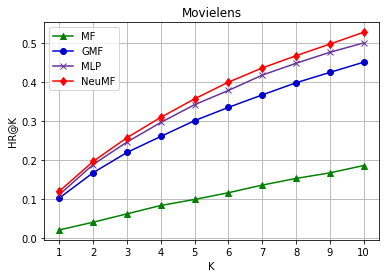

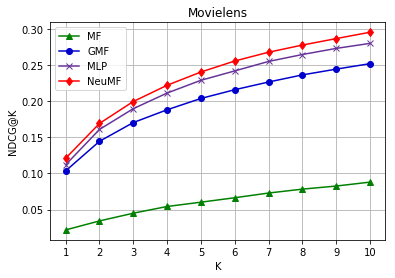

In [ ]:
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
K_values = [i for i in range(1,maxK+1)]
path_to_save_figures = "Figures/"

plt.figure("K")
plt.plot(K_values, hits_MF, color=color_MF, marker="^")
plt.plot(K_values, hits_GMF, color=color_GMF, marker="o")
plt.plot(K_values, hits_MLP, color=color_MLP, marker="x")
plt.plot(K_values, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("K")
plt.ylabel("HR@K")
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Movielens")
plt.xticks(K_values)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment4_hr_movielens.png")

plt.figure("K2")
plt.plot(K_values, ndcgs_MF, color=color_MF, marker="^")
plt.plot(K_values, ndcgs_GMF, color=color_GMF, marker="o")
plt.plot(K_values, ndcgs_MLP, color=color_MLP, marker="x")
plt.plot(K_values, ndcgs_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("K")
plt.ylabel("NDCG@K")
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Movielens")
plt.xticks(K_values)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment4_ndcg_movielens.png")

plt.show()

#### Dataset Pinterest

In [ ]:
MF = get_model_MF(num_users=num_users_pinterest, num_items=num_items_pinterest)
GMF = get_model_GMF(num_users=num_users_pinterest, num_items=num_items_pinterest)
MLP = get_model_MLP(num_users=num_users_pinterest, num_items=num_items_pinterest)
NeuMF = get_model_NeuMF(num_users=num_users_pinterest, num_items=num_items_pinterest)

print("Training of every model over 3 epochs...\n")

MF.fit(x=train_features_pinterest, y=train_labels_pinterest, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
GMF.fit(x=train_features_pinterest, y=train_labels_pinterest, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
MLP.fit(x=train_features_pinterest, y=train_labels_pinterest, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)
NeuMF.fit(x=train_features_pinterest, y=train_labels_pinterest, batch_size=batch_size, epochs=3, verbose=0, shuffle=True)

maxK = 10
hits, ndcgs = [], []

start = time()

for K in range(1, maxK+1):
    print("Evaluation of Top-K item recommendation for K={:.0f}".format(K))
    hit, ndcg = evaluate_models(models=[MF, GMF, MLP, NeuMF], test_set=test_set_pinterest, K=K)
    hits.append(hit)
    ndcgs.append(ndcg)

hits, ndcgs = np.array(hits), np.array(ndcgs)

hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))

Training of every model over 3 epochs...

Evaluation of Top-K item recommendation for K=1
Evaluation of Top-K item recommendation for K=2
Evaluation of Top-K item recommendation for K=3
Evaluation of Top-K item recommendation for K=4
Evaluation of Top-K item recommendation for K=5
Evaluation of Top-K item recommendation for K=6
Evaluation of Top-K item recommendation for K=7
Evaluation of Top-K item recommendation for K=8
Evaluation of Top-K item recommendation for K=9
Evaluation of Top-K item recommendation for K=10

Running time : 4 min 51 sec


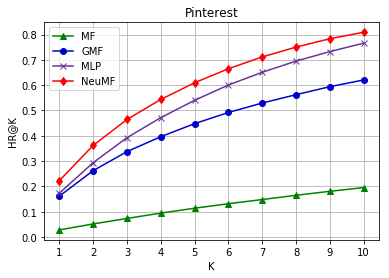

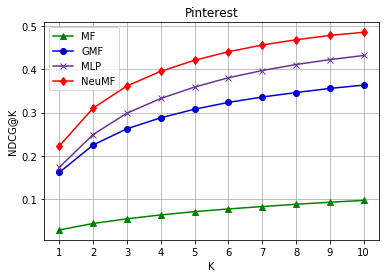

In [ ]:
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
K_values = [i for i in range(1,maxK+1)]
path_to_save_figures = "Figures/"

plt.figure("K")
plt.plot(K_values, hits_MF, color=color_MF, marker="^")
plt.plot(K_values, hits_GMF, color=color_GMF, marker="o")
plt.plot(K_values, hits_MLP, color=color_MLP, marker="x")
plt.plot(K_values, hits_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("K")
plt.ylabel("HR@K")
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.xticks(K_values)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment4_hr_pinterest.png")

plt.figure("K2")
plt.plot(K_values, ndcgs_MF, color=color_MF, marker="^")
plt.plot(K_values, ndcgs_GMF, color=color_GMF, marker="o")
plt.plot(K_values, ndcgs_MLP, color=color_MLP, marker="x")
plt.plot(K_values, ndcgs_NeuMF, color=color_NeuMF, marker="d")
plt.xlabel("K")
plt.ylabel("NDCG@K")
plt.legend(("MF","GMF","MLP","NeuMF",))
plt.title("Pinterest")
plt.xticks(K_values)
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment4_ndcg_pinterest.png")

plt.show()

Ici nous allons faire varier le nombre de couches et le nombre de neurones par couches dans le MLP.

#### Dataset MovieLens

In [ ]:
start = time()

factors = [8,16,32,64]
hits, ndcgs = [], []
max_num_hidden_layers = 4

for num_hidden_layers in range(max_num_hidden_layers+1):
    print()
    print("Number of hidden layers:", num_hidden_layers)
    models_MLP = []
    for f in factors:
        print("Number of predictive factors : {}".format(f))
        MLP = get_model_MLP(num_users=num_users_movielens, num_items=num_items_movielens, num_layers=num_hidden_layers, factors=f)
        MLP.fit(x=train_features_movielens, y=train_labels_movielens, epochs=3, batch_size=batch_size, shuffle=True, verbose=0)
        models_MLP.append(MLP)
    hits_hidden_layers, ndcgs_hidden_layers = evaluate_models(models=models_MLP, test_set=test_set_movielens, K=K)
    hits.append(hits_hidden_layers)
    ndcgs.append(ndcgs_hidden_layers)

hits, ndcgs = np.transpose(np.array(hits)), np.transpose(np.array(ndcgs))

print("\nHits:")
print(hits)
print("\nNDCGs")
print(ndcgs)

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Number of hidden layers: 0
Number of predictive factors : 8
Number of predictive factors : 16
Number of predictive factors : 32
Number of predictive factors : 64

Number of hidden layers: 1
Number of predictive factors : 8
Number of predictive factors : 16
Number of predictive factors : 32
Number of predictive factors : 64

Number of hidden layers: 2
Number of predictive factors : 8
Number of predictive factors : 16
Number of predictive factors : 32
Number of predictive factors : 64

Number of hidden layers: 3
Number of predictive factors : 8
Number of predictive factors : 16
Number of predictive factors : 32
Number of predictive factors : 64

Number of hidden layers: 4
Number of predictive factors : 8
Number of predictive factors : 16
Number of predictive factors : 32
Number of predictive factors : 64

Hits:
[[0.45215232 0.44966887 0.45596026 0.51142384 0.56639073]
 [0.44917219 0.45066225 0.48890728 0.56556291 0.6160596 ]
 [0.45281457 0.46423841 0.55496689 0.60596026 0.64718543]
 [0.

#### Dataset Pinterest

In [ ]:
start = time()

factors = [8,16,32,64]
hits, ndcgs = [], []
max_num_hidden_layers = 4

for num_hidden_layers in range(max_num_hidden_layers+1):
    print()
    print("Number of hidden layers:", num_hidden_layers)
    models_MLP = []
    for f in factors:
        print("Number of predictive factors : {}".format(f))
        MLP = get_model_MLP(num_users=num_users_pinterest, num_items=num_items_pinterest, num_layers=num_hidden_layers, factors=f)
        MLP.fit(x=train_features_pinterest, y=train_labels_pinterest, epochs=3, batch_size=batch_size, shuffle=True, verbose=0)
        models_MLP.append(MLP)
    hits_hidden_layers, ndcgs_hidden_layers = evaluate_models(models=models_MLP, test_set=test_set_pinterest, K=K)
    hits.append(hits_hidden_layers)
    ndcgs.append(ndcgs_hidden_layers)

hits, ndcgs = np.transpose(np.array(hits)), np.transpose(np.array(ndcgs))

print("\nHits:")
print(hits)
print("\nNDCGs")
print(ndcgs)

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Number of hidden layers: 0
Number of predictive factors : 8
layers: []
Number of predictive factors : 16
layers: []
Number of predictive factors : 32
layers: []
Number of predictive factors : 64
layers: []

Number of hidden layers: 1
Number of predictive factors : 8
layers: [8]
Number of predictive factors : 16
layers: [16]
Number of predictive factors : 32
layers: [32]
Number of predictive factors : 64
layers: [64]

Number of hidden layers: 2
Number of predictive factors : 8
layers: [16, 8]
Number of predictive factors : 16
layers: [32, 16]
Number of predictive factors : 32
layers: [64, 32]
Number of predictive factors : 64
layers: [128, 64]

Number of hidden layers: 3
Number of predictive factors : 8
layers: [32, 16, 8]
Number of predictive factors : 16
layers: [64, 32, 16]
Number of predictive factors : 32
layers: [128, 64, 32]
Number of predictive factors : 64
layers: [256, 128, 64]

Number of hidden layers: 4
Number of predictive factors : 8
layers: [64, 32, 16, 8]
Number of pred

In [ ]:
travel_filepath = "Data/Travel_28K.csv"
df = pd.read_csv(filepath_or_buffer=travel_filepath)
df.head()

,user,item
0,0,7
1,0,4
2,0,46
3,0,6
4,0,37


In [ ]:
def get_dataset_airline(travel_filepath, num_negative_instances, num_items):
    df = pd.read_csv(filepath_or_buffer=travel_filepath)
    ones = np.ones(shape=(len(df.values),1))
    positive_interactions = np.concatenate((df.values, ones), axis=1).astype(dtype="int64")
    train_set, test_set = [], []
    current_user = -1
    interactions_for_this_user = []
    for interaction in positive_interactions:
        user, item = interaction[0], interaction[1]
        if user==current_user:
            train_set.append(interaction)
            interactions_for_this_user.append(item)
        else:
            num_interactions = len(interactions_for_this_user)
            for i in range(num_negative_instances * num_interactions):
                random_item = np.random.randint(num_items)
                while (random_item in interactions_for_this_user):
                    random_item = np.random.randint(num_items)
                train_set.append([current_user, random_item, 0])
                interactions_for_this_user.append([current_user, random_item, 0])
            current_user = user
            positive_item = item
            items_test_for_this_user = [positive_item]
            interactions_for_this_user = []
            for i in range(99):
                random_item = np.random.randint(num_items)
                while random_item in items_test_for_this_user:
                    random_item = np.random.randint(num_items)
                items_test_for_this_user.append(random_item)
            test_set.append(items_test_for_this_user)
    for i in range(num_negative_instances * num_interactions):
        random_item = np.random.randint(num_items+1)
        while (random_item in interactions_for_this_user):
            random_item = np.random.randint(num_items+1)
        train_set.append([current_user, random_item, 0])
    return np.array(train_set), np.array(test_set)

In [ ]:
print("\n*** Preprocessing of data ***")

num_users_airline, num_items_airline = number_users_and_items(path=travel_filepath, sep=",", title_columns=True)
train_set_airline, test_set_airline = get_dataset_airline(travel_filepath=travel_filepath, num_negative_instances=2, num_items=num_items_airline)

print("\nAirline Travel Dataset")
print("Number of users : {}".format(num_users_airline))
print("Number of items : {}".format(num_items_airline))
print("Number of training interactions : {}".format(len(train_set_airline)))
train_features_airline = [train_set_airline[:,0], train_set_airline[:,1]]
train_labels_airline = train_set_airline[:,2]

print("\nDataset loaded successfully !")


*** Preprocessing of data ***

Airline Travel Dataset
Number of users : 3842
Number of items : 138
Number of training interactions : 73578

Dataset loaded successfully !


In [ ]:
start = time()

MF_airline = get_model_MF(num_users=num_users_airline, num_items=num_items_airline)
GMF_airline = get_model_GMF(num_users=num_users_airline, num_items=num_items_airline)
MLP_airline = get_model_MLP(num_users=num_users_airline, num_items=num_items_airline)
NeuMF_airline = get_model_NeuMF(num_users=num_users_airline, num_items=num_items_airline)

models_airline = [MF_airline, GMF_airline, MLP_airline, NeuMF_airline]

hits, ndcgs, losses = train_models(models=models_airline, train_features=train_features_airline, train_labels=train_labels_airline, 
                                   test_set=test_set_airline, batch_size=256, epochs=epochs, K=K)

loss_MF, loss_GMF, loss_MLP, loss_NeuMF = losses[:,0], losses[:,1], losses[:,2], losses[:,3]
hits_MF, hits_GMF, hits_MLP, hits_NeuMF = hits[:,0], hits[:,1], hits[:,2], hits[:,3]
ndcgs_MF, ndcgs_GMF, ndcgs_MLP, ndcgs_NeuMF = ndcgs[:,0], ndcgs[:,1], ndcgs[:,2], ndcgs[:,3]

run_time = time()-start
print("\nRunning time : {:.0f} min {:.0f} sec".format(run_time//60, run_time%60))


Epoch n°1/10
73578/73578 - 1s - loss: 3.6094
73578/73578 - 1s - loss: 0.6741
73578/73578 - 2s - loss: 0.4764
73578/73578 - 2s - loss: 0.5376

Epoch n°2/10
73578/73578 - 1s - loss: 3.1463
73578/73578 - 1s - loss: 0.6169
73578/73578 - 1s - loss: 0.3823
73578/73578 - 1s - loss: 0.4258

Epoch n°3/10
73578/73578 - 1s - loss: 2.7646
73578/73578 - 1s - loss: 0.4570
73578/73578 - 1s - loss: 0.3728
73578/73578 - 1s - loss: 0.3992

Epoch n°4/10
73578/73578 - 1s - loss: 2.3699
73578/73578 - 1s - loss: 0.3793
73578/73578 - 1s - loss: 0.3613
73578/73578 - 1s - loss: 0.3578

Epoch n°5/10
73578/73578 - 1s - loss: 2.0211
73578/73578 - 1s - loss: 0.3529
73578/73578 - 1s - loss: 0.3499
73578/73578 - 1s - loss: 0.3190

Epoch n°6/10
73578/73578 - 1s - loss: 1.7664
73578/73578 - 1s - loss: 0.3334
73578/73578 - 1s - loss: 0.3367
73578/73578 - 1s - loss: 0.2875

Epoch n°7/10
73578/73578 - 1s - loss: 1.5281
73578/73578 - 1s - loss: 0.3163
73578/73578 - 1s - loss: 0.3197
73578/73578 - 1s - loss: 0.2638

Epoch

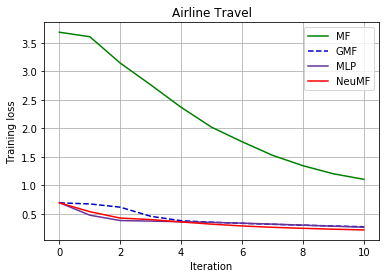

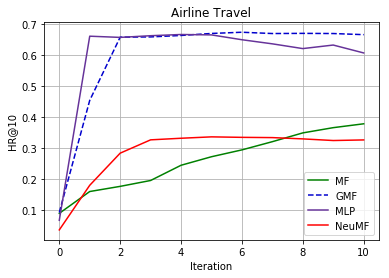

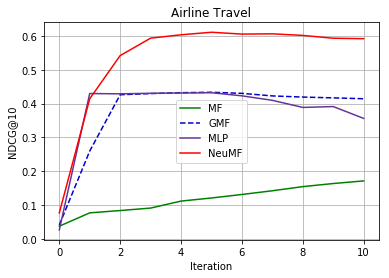

In [ ]:
iterations = [e for e in range(epochs+1)]
color_MF, color_GMF, color_MLP, color_NeuMF = "green", "mediumblue", "rebeccapurple", "red"
path_to_save_figures = "Figures/"

plt.figure("loss_airline")
plt.plot(iterations, loss_MF, color=color_MF)
plt.plot(iterations, loss_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, loss_MLP, color=color_MLP)
plt.plot(iterations, loss_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("Airline Travel")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment6_loss_airline.png")

plt.figure("hits_airline")
plt.plot(iterations, hits_MF, color=color_MF)
plt.plot(iterations, hits_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, hits_MLP, color=color_MLP)
plt.plot(iterations, ndcgs_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("HR@"+str(K))
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("Airline Travel")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment6_hr_airline.png")

plt.figure("ndcgs_airline")
plt.plot(iterations, ndcgs_MF, color=color_MF)
plt.plot(iterations, ndcgs_GMF, color=color_GMF, linestyle="dashed")
plt.plot(iterations, ndcgs_MLP, color=color_MLP)
plt.plot(iterations, hits_NeuMF, color=color_NeuMF)
plt.xlabel("Iteration")
plt.ylabel("NDCG@"+str(K))
plt.legend(("MF", "GMF","MLP","NeuMF",))
plt.title("Airline Travel")
plt.grid()
plt.savefig(fname=path_to_save_figures+"experiment6_ndcg_airline.png")

plt.show()